In [1]:
import os
import glob
import pickle
import argparse
import numpy as np
import pandas as pd

parser = argparse.ArgumentParser()
# parser.add_argument('--wlan', type=str, default='wlan0')
args = parser.parse_args('')
args.mac_list_path = f'./device/save/mac_list.pkl'


## Make training data

In [2]:

#################################################
####################  Utils  ####################

def create_null_df():
    # find mac list
    with open(args.mac_list_path, 'rb') as fp:
        mac_list = pickle.load(fp)
    
    # create df
    data = {'x':[], 'y':[], 'z':[], 'timestamp':[]}
    data.update({mac:[] for mac in mac_list})
    
    df = pd.DataFrame(data=data)
    return df

#################################################
##############  device & data path  #############

device_path = './device_won/'
data_path = './data_won/'

#################################################
##############  make training data  #############

os.system('mkdir -p {data_path}/')

def make_training_data(wlan):
    wlan_df = create_null_df()

    for csv in glob.glob(f'{device_path}/save/{wlan.strip()}/*.csv'):
        point_df = pd.read_csv(csv)
        wlan_df = pd.concat([wlan_df, point_df], ignore_index=True)
    wlan_df.to_csv(f'{data_path}/{wlan.strip()}.csv', index=False)
    
    return wlan_df
    
wlan_dfs = []    
for wlan in ['wlan0', 'wlan1', 'wlan2']:
    wlan_df = make_training_data(f'{wlan.strip()}')
    wlan_dfs.append(wlan_df)


## Preprocessing

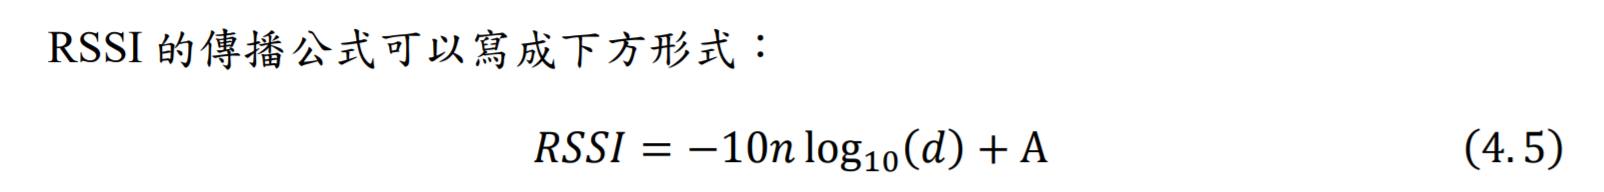

* 取10底數
```
    10^-RSSI = Dist * C 
```


## Preprocessing

In [3]:

# read training data
wlan_dfs = []
for wlan in ['wlan0', 'wlan1', 'wlan2']:
    wlan_dfs.append(pd.read_csv(f'{data_path}/{wlan.strip()}.csv'))

#################################################
##############  data preprocessing  #############

# 取 exp : y = e^(-x/80)
normalized_wlan_dfs = []
for wlan_df in wlan_dfs:
    sel_indexs = list(wlan_df.columns)[4:]
    wlan_df = wlan_df.copy()
#     wlan_df[sel_indexs] = (-wlan_df[sel_indexs]/80).apply(np.exp)
    normalized_wlan_dfs.append(wlan_df)

# find clean mac list
normalized_cleaned_wlan_dfs = []
for i in range(3):
    wlan_df = normalized_wlan_dfs[i]
    
    mac_list = []
    for mac_, na_ in zip(wlan_df.columns[4:], wlan_df.isna().sum()[4:]):
        if na_ < 80:
            mac_list.append(mac_)
    
    selec_col = ['x','y','z','timestamp'] + mac_list
    normalized_cleaned_wlan_dfs.append(wlan_df[selec_col].copy())

# fill nan to 0
# for i in range(3):
#     normalized_cleaned_wlan_dfs[i] = normalized_cleaned_wlan_dfs[i].fillna(0)


## Visualization

In [7]:
# point to mesh
def point_to_mesh(wlan_df, mac):
    X, Y, Z = [], [], []
    
    group_wlan_df = wlan_df.copy().sort_values(['x','y']).groupby(['x','y']).mean()
    
    indexs = np.array([[item[0], item[1]]for item in list(group_wlan_df.index)])
    x_set, y_set = sorted(set(list(indexs[:,0]))), sorted(set(list(indexs[:,1])))
    
    for x in x_set:
        for y in y_set:
            X.append(x)
            Y.append(y)
            try:
                z = group_wlan_df.xs(x, level=0, axis=0, drop_level=False).xs(y, level=1, axis=0, drop_level=True)[mac.strip().upper()].values[0]
                if np.isnan(z):
                    z = -40
            except:
                z = Z[-1] if len(Z) else -40
            Z.append(z)

    X = np.array(X).reshape((len(x_set), -1))
    Y = np.array(Y).reshape((-1, len(y_set)))
    Z = np.array(Z).reshape((len(x_set), len(y_set)))

    return X, Y, Z



No handles with labels found to put in legend.


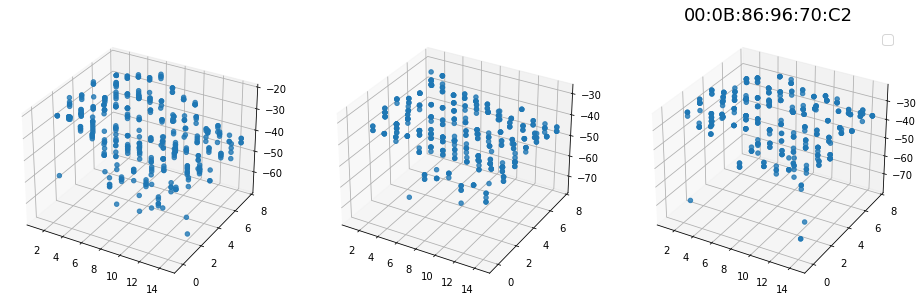

In [8]:
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

fig = plt.figure(figsize=(16, 9))
mac = '00:11:32:ad:8c:82'
for i, wlan_df in enumerate(normalized_cleaned_wlan_dfs):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    X = np.array(wlan_df['x'])
    Y = np.array(wlan_df['y'])
    Z = np.array(wlan_df[mac.upper()])
    ax.scatter(X, Y, Z, alpha=0.8, cmap=cm.viridis) # hot viridis jet
ax.legend(fontsize=14)
ax.set_title('00:0B:86:96:70:C2', fontsize=18)
plt.show()
# fig.savefig('config/optimize_surface.png', dpi=100)


AP[1] MAC:[00:11:32:9d:30:3a]


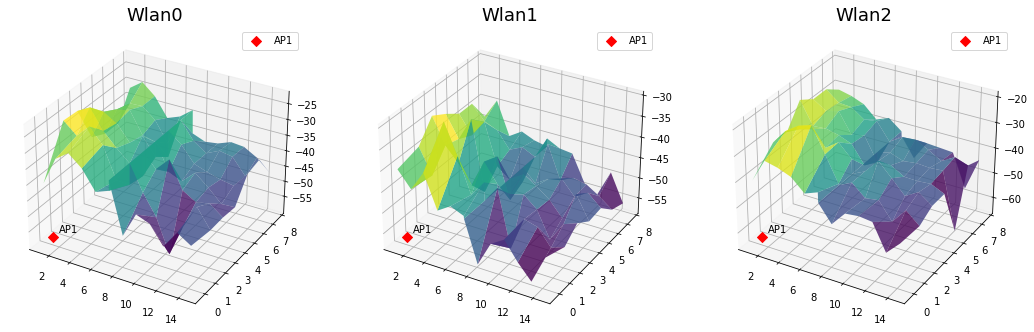


AP[2] MAC:[00:11:32:ad:8c:82]


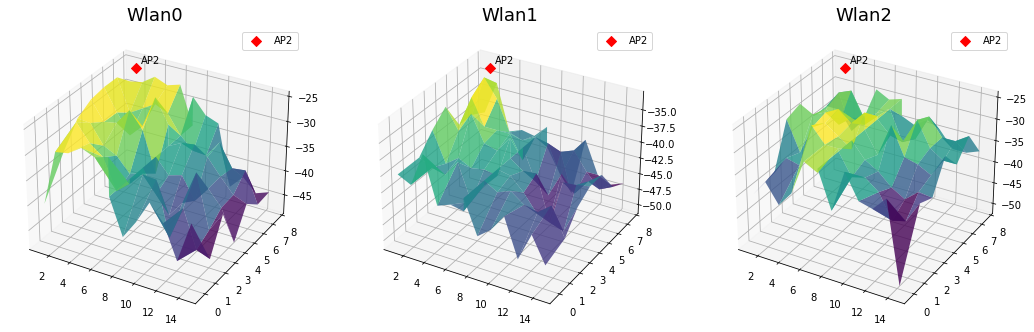


AP[3] MAC:[00:11:32:ad:8e:b7]


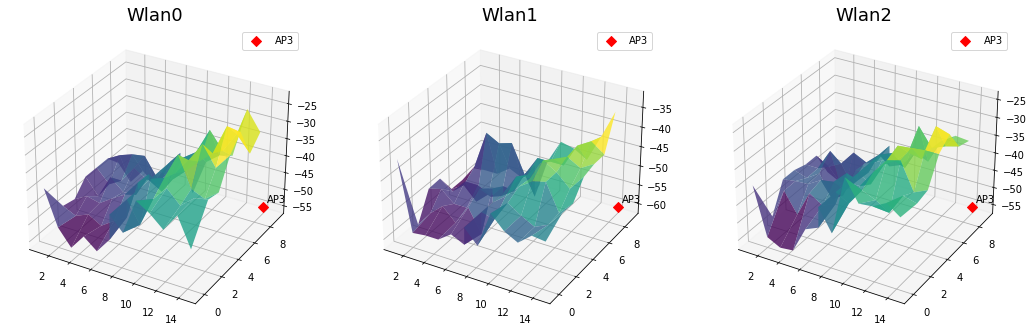


AP[4] MAC:[00:11:32:9d:2b:30 ]


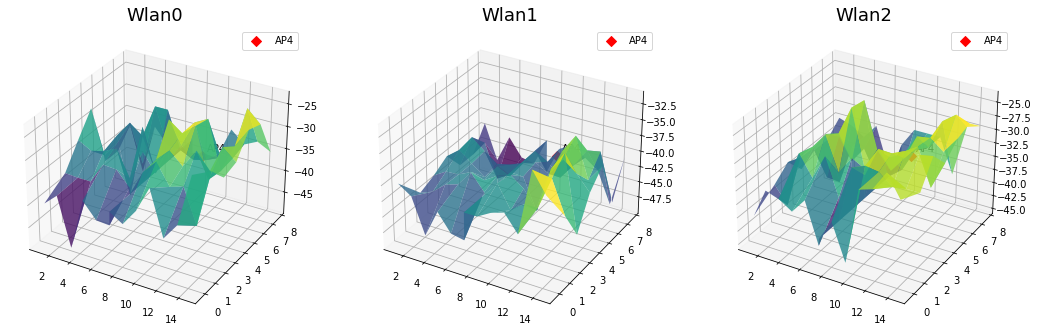

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

ap_mac_list = ['00:11:32:9d:30:3a', '00:11:32:ad:8c:82', '00:11:32:ad:8e:b7', '00:11:32:9d:2b:30 '] # TA's Acess Points
ap_position = [(1.4, 0, 0), (1.85, 7.44, 1), (14.05, 9.06, 0), (13.9, 1.27, 1)]

for i, mac_ in enumerate(ap_mac_list):
    fig = plt.figure(figsize=(18, 6))
    for j, wlan_df in enumerate(normalized_cleaned_wlan_dfs):
        ax = plt.subplot(1, 3, j+1, projection='3d')
        X, Y, Z = point_to_mesh(wlan_df, mac_)
        ax.plot_surface(X, Y, Z, alpha=0.8, cmap=cm.viridis) # hot viridis jet
        ax.scatter(ap_position[i][0], ap_position[i][1], Z.min() if ap_position[i][2]==0 else Z.max(), marker='D', label=f'AP{i+1}', s=50, color='red')
        ax.text(ap_position[i][0], ap_position[i][1]+0.5, Z.min() if ap_position[i][2]==0 else Z.max(), f'AP{i+1}')
        ax.set_title(f'Wlan{j}', fontsize=18)
        ax.legend()
    print(f'\nAP[{i+1}] MAC:[{mac_}]')
    plt.show()